# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper
## stdF1 = stdF2 = 0.03

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate

## Parameters

In [2]:
n_bins = 200
# n_samples is the number of eddy turnovers
n_samples = 850

Tr = 2*np.pi

## Functions

In [3]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(Tr, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(Tr, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's
def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=0
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
        y1=F1[i]
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=0
    F2=[]

    for i in range(len(t)):
        arr=[]
        time=t[i]
        stdevt=((1-math.exp(-2*time/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-time/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
        y1=F2[i]
    return F2

#To Generate G1, I take the derivative of F1 by taking the difference of F1 values at times halfway between consecutive delta T's and divide that by the difference in those times

def funG1():

    G1=[0]
    for i in range(len(F1)-1):
        G1.append((F1[i+1]-F1[i])/(deltaT[i]+deltaT[i+1]))
    return G1


def funAmp(dAdT, AT):

    #A is the amplitude
    A=[]
    #t is time
    t=[]
    #derivA is the derivative of A with respect to time
    derivA=[]
    f1=[]
    g1=[]
    f2=[]
    
    #F2=constant=c
    #1+G1=constant=b
    #F1=constant=a
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        q=1/2*(4*b-a**2)**(1/2)
        
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C0prime=math.exp(-a*Tturb[i]/2)*C0
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        C1prime=math.exp(-a*(Tturb[i])/2)*C1
        
                
        #Ttemp is an array containing the times between each eddy turnover 
        #(which starts at 0 and ends at deltaT)
        Ttemp=np.linspace(0, deltaT[i])
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(Tturb[i]+j)
                f1.append(a)
                g1.append(b-1)
                f2.append(c)
                
                A.append(math.exp(-a*j/2)*(C0prime*math.sin(q*(Tturb[i]+j))+C1prime*math.cos(q*(Tturb[i]+j)))+c/b)
                derivA.append(math.exp(-a*j/2)*((C0prime*q-C1prime*a/2)*math.cos(q*(Tturb[i]+j))-(C0prime*a/2+C1prime*q)*math.sin(q*(Tturb[i]+j))))
                
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        dAdT=derivA[-1]
        AT=A[-1]
            
    
    return A, t, f1, g1, f2

In [4]:
# Average value of Amplitude
def FunavgA(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = sum(Asqr) / len(Asqr)
    return avg

# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# 1/2*log(A^2)
# same as log(abs(A)) above
def FunHalfLogASqr(A):
    logAsqr = []
    for i in A:
        logAsqr.append(1/2*math.log10(i*i))
    return logAsqr

# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    

### Parameters

In [5]:
# variables for generating F1
meanF1 = 0
stdF1 = .03

# variables for generating F2

stdF2 =.03
meanF2 = 0

# initial conditions A(0)=1/2*stdF2, dA/dT(0)=0
dAdT = 0
AT = 1/2*stdF2

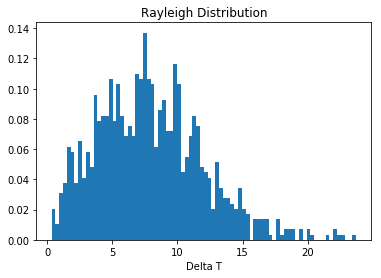

In [6]:
rayleighdistribution()

deltaT = fundeltaT(n_bins, n_samples)

Tturb, time = funTturb()

t = funt()

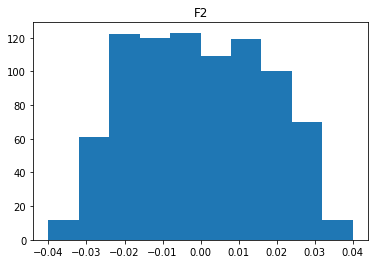

Average Value of F2  -0.00031572602568180814
Maximum Value of F2  0.042385076782685716
Minimum Value of F2  -0.036902412310969614


In [7]:
F2 = funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2-.01, stdF2+.01))
plt.title("F2")
plt.show()

avgF2 = sum(F2) / len(F2)
print("Average Value of F2 ", avgF2)
print("Maximum Value of F2 ", max(F2))
print("Minimum Value of F2 ", min(F2))

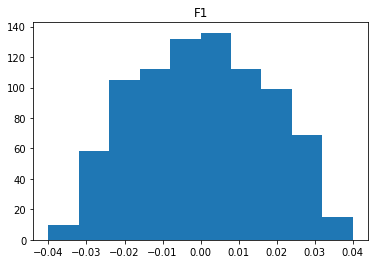

<F1^2>^(1/2) =  0.01694905824965978
Average Value of F1  0.0006582025789773549
Maximum Value of F2  0.04207861413259037
Minimum Value of F1  -0.037261601201285556


In [8]:
F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1-.01, stdF1+.01))
plt.title("F1")
plt.show()

F1sqr=[]
for i in range(len(F1)-1):
    F1sqr.append(F1[i]**2)

rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)

avgF1 = sum(F1) / len(F1)
print("Average Value of F1 ", avgF1)

print("Maximum Value of F2 ", max(F1))
    
print("Minimum Value of F1 ", min(F1))

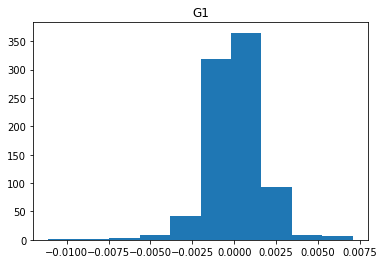

Average Value of G1  -1.310174938145171e-05


In [9]:
G1=funG1()
plt.hist(G1, 10)
plt.title("G1")
plt.show()

avgG1 = sum(G1) / len(G1)
print("Average Value of G1 ", avgG1)

##  F1 vs. Time, Amplitude of mode vs. Time, G1 vs. Time, F2 vs. Time, log(A) vs. Time

<Figure size 2880x720 with 0 Axes>

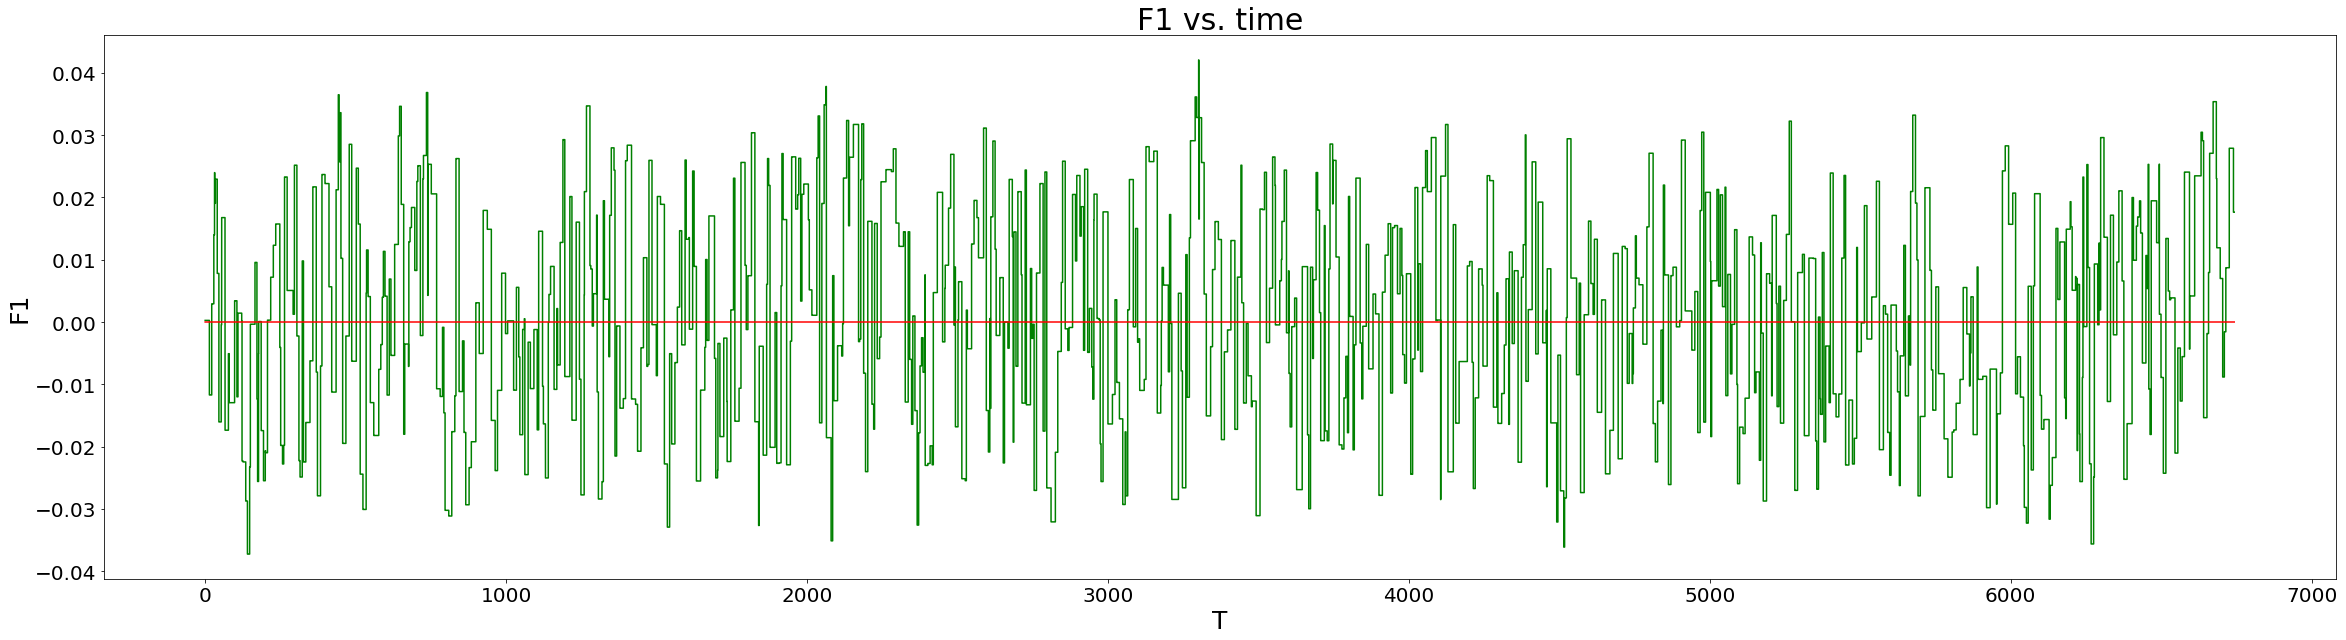

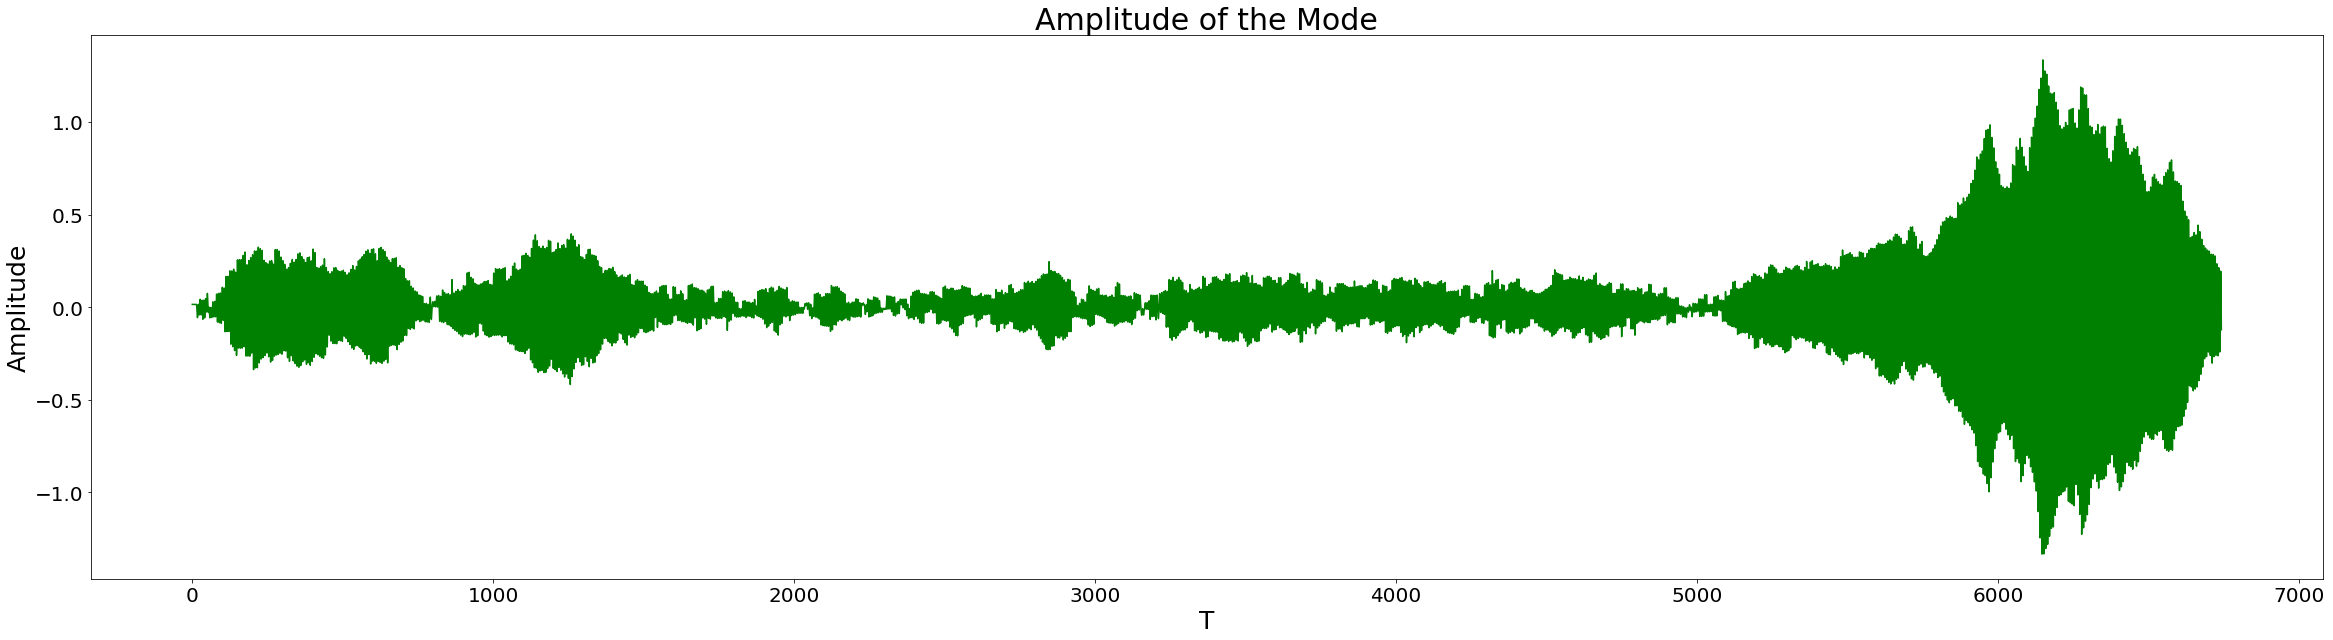

Amplitude of mode for 850 eddy turnovers

 Average value of the amplitude squared = 0.06140717809620193


In [10]:
plt.figure(figsize=(40,10))
A, t, f1, g1, f2 =funAmp(dAdT, AT)
axis_font = {'size':'25'}
title_font = {'size':'30'}

zero=[]

for i in range(len(t)):
    zero.append(0)
    
plt.figure(figsize=(40,10))    
plt.plot(t, f1, 'g', t, zero, 'r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('T', **axis_font)
plt.ylabel('F1', **axis_font)
plt.title('F1 vs. time', **title_font)
plt.show()

plt.figure(figsize=(40,10))
plt.plot(t, A, 'g')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('T', **axis_font)
plt.ylabel('Amplitude', **axis_font)
plt.title('Amplitude of the Mode', **title_font)
plt.show()

avg= FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)

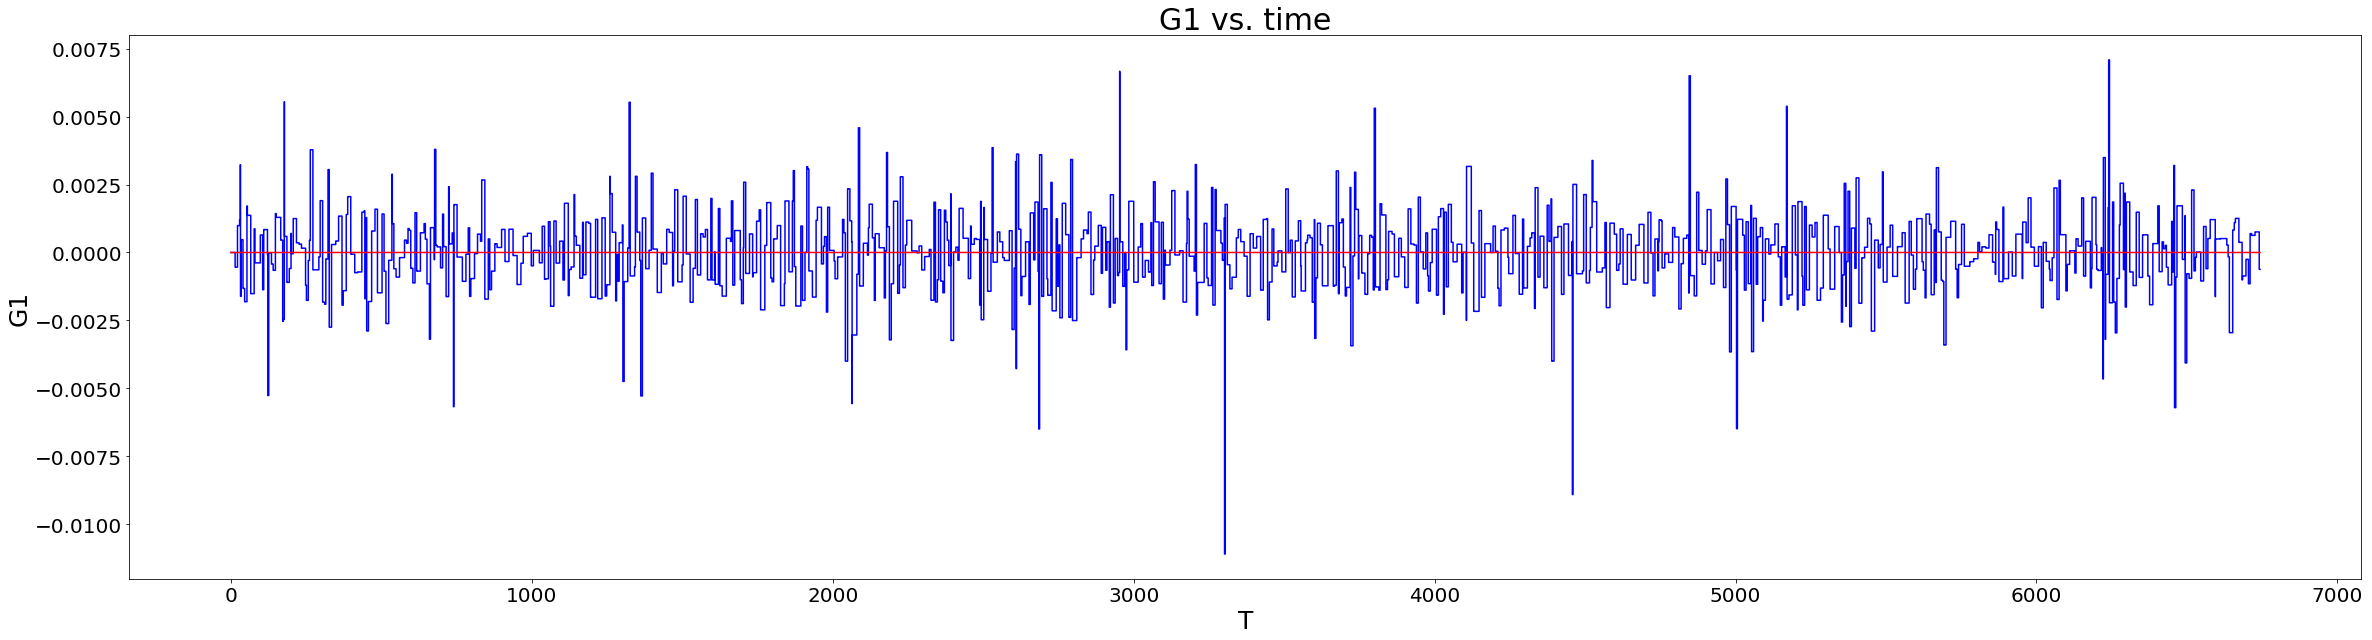

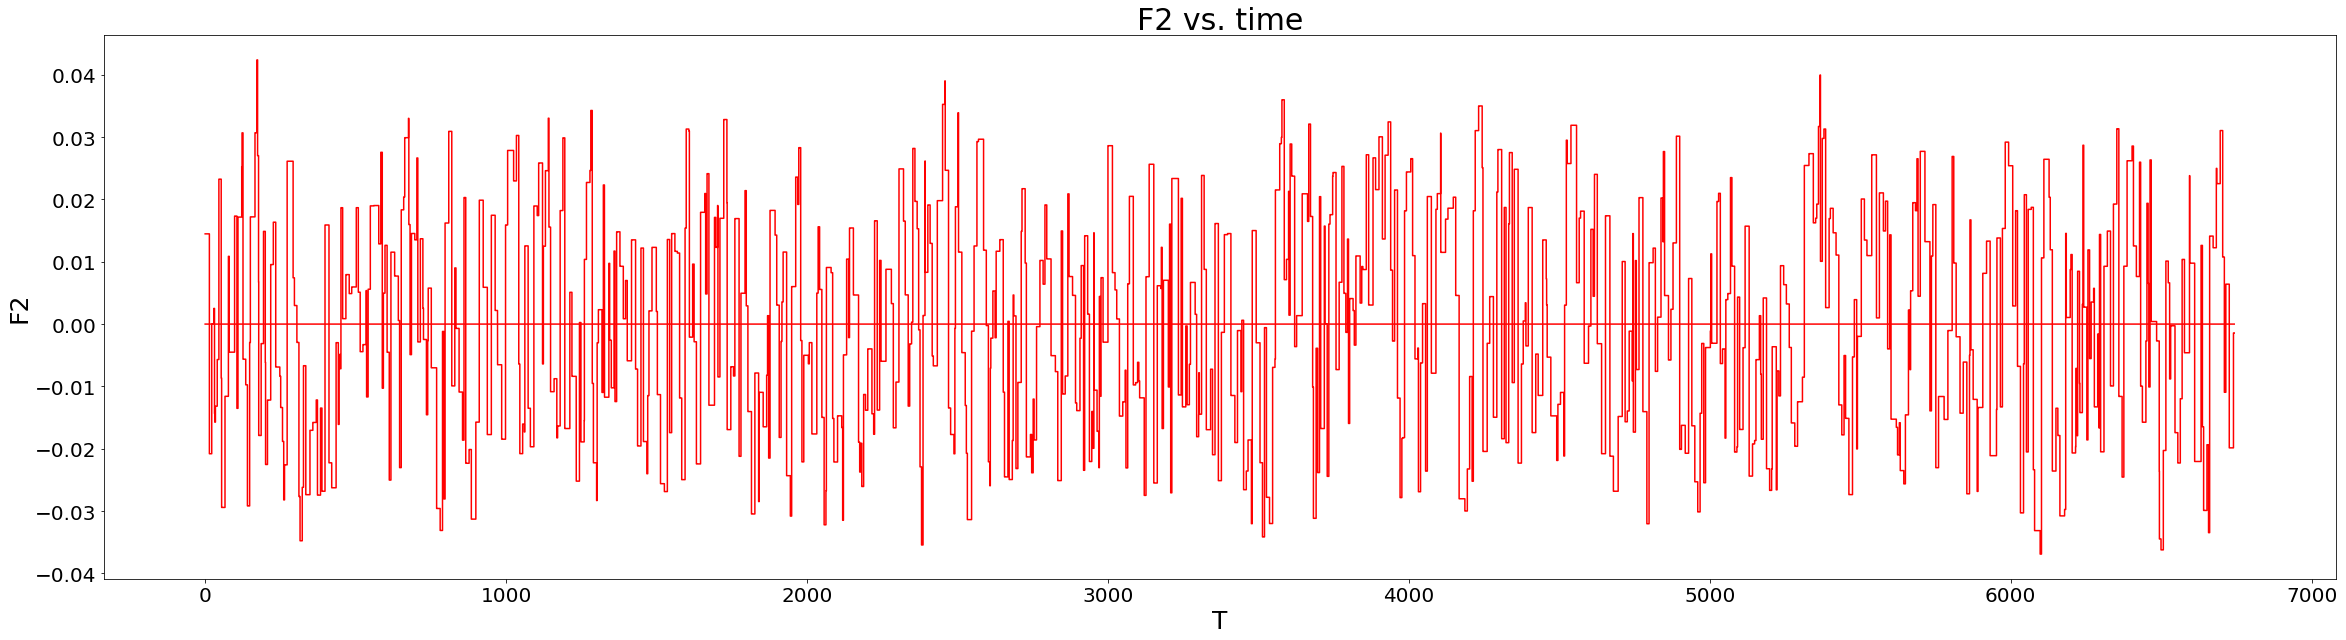

In [11]:
plt.figure(figsize=(40,10))    
plt.plot(t, g1, 'b', t, zero, 'r')
plt.xlabel('T', **axis_font)
plt.ylabel('G1', **axis_font)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('G1 vs. time', **title_font)
plt.show()

plt.figure(figsize=(40,10))
plt.plot(t, f2, 'r', t, zero, 'r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('T', **axis_font)
plt.ylabel('F2', **axis_font)
plt.title('F2 vs. time', **title_font)
plt.show()

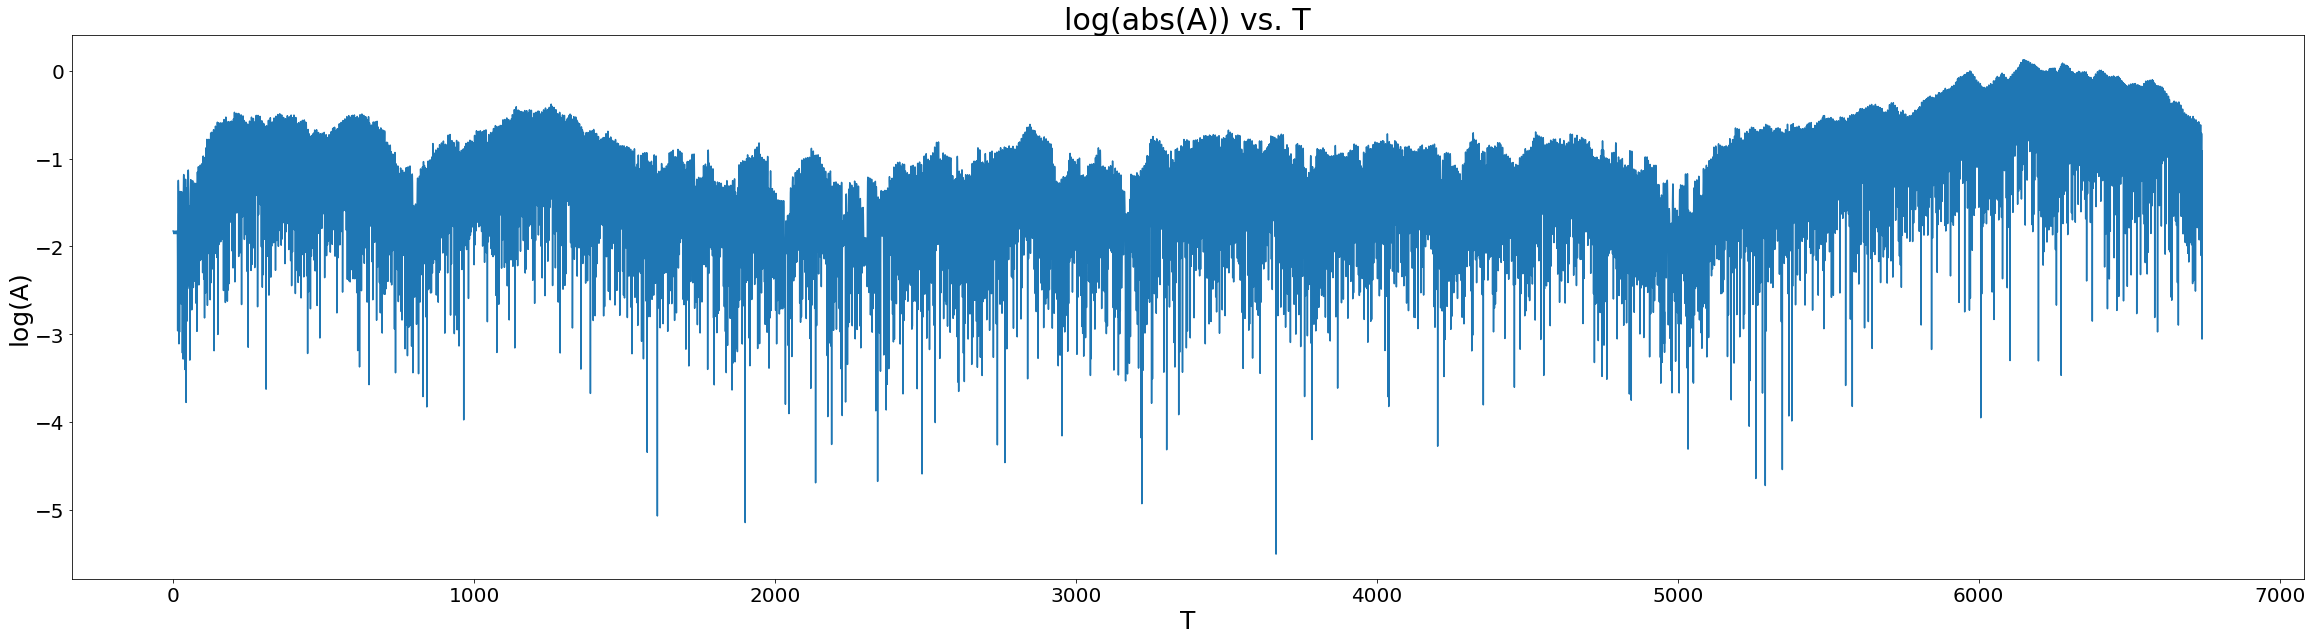

In [12]:
# log of absolute value of A
logA = FunLog(A)
plt.figure(figsize = (40,10))
plt.plot(t,logA)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('T', **axis_font)
plt.ylabel('log(A)', **axis_font)
plt.title('log(abs(A)) vs. T', **title_font)
plt.show()

## Amplification Distribution Function

### Parameters for Amplification Distribution

In [13]:
# T(max) is the total duration of the simulation
Tmax = t[-1]

# want Tmax ~ 2*pi*10^4
print("T(max) =", Tmax)

# divide T(max), the total duration, into equal segments delt = 2*pi*N
# choose N = 1
N = 1
delt = 2 * np.pi * N
print("delt =", delt)

T(max) = 6742.826952022274
delt = 6.283185307179586


In [14]:
# root mean square of amplitude for T(max)
RMStot= FunRMS(A)
print("the root mean square of the amplitude over T(max) is", RMStot)

the root mean square of the amplitude over T(max) is 0.24780471766332846


In [15]:
# the number of segments is the total time (Tmax)/delT
numsegments = int(Tmax/delt)+1

# 2d array containing an array for amplitudes in each segments
ampsegments = []

# this loop divides the total duration T(max) into equal segments of delT
i=0
for count in range(0, numsegments):
    ampsegment = []
    while i < len(t)-1:
        if (t[i] < (count+1)*2*np.pi):
            ampsegment.append(A[i])
            i+=1
        else:
            break        
    ampsegments.append(ampsegment)

# amp is the root mean square (RMS) of A in delT / RMS of A in Tmax    
amp = []    
for ampsegment in ampsegments:
    amp.append(FunRMS(ampsegment)/RMStot)

In [16]:
dAmp = []
inr=0
for i in range(len(amp)):
    # choose dAmp = 0.01 * Amp
    tempdAmp = 0.01*amp[i]
    for j in range(len(amp)):
        # find Amp that is in the range Amp to Amp + dAmp
        if (amp[j] >= amp[i] and amp[j] <= amp[i]+ tempdAmp):
            inr += 1
    dAmp.append(tempdAmp)  

In [17]:
# df is the fraction of Tmax that Amp is in the range Amp to Amp + dAmp
df=inr/len(t)
dfdAmp=[]
for i in range(len(dAmp)):
    dfdAmp.append(df/dAmp[i])

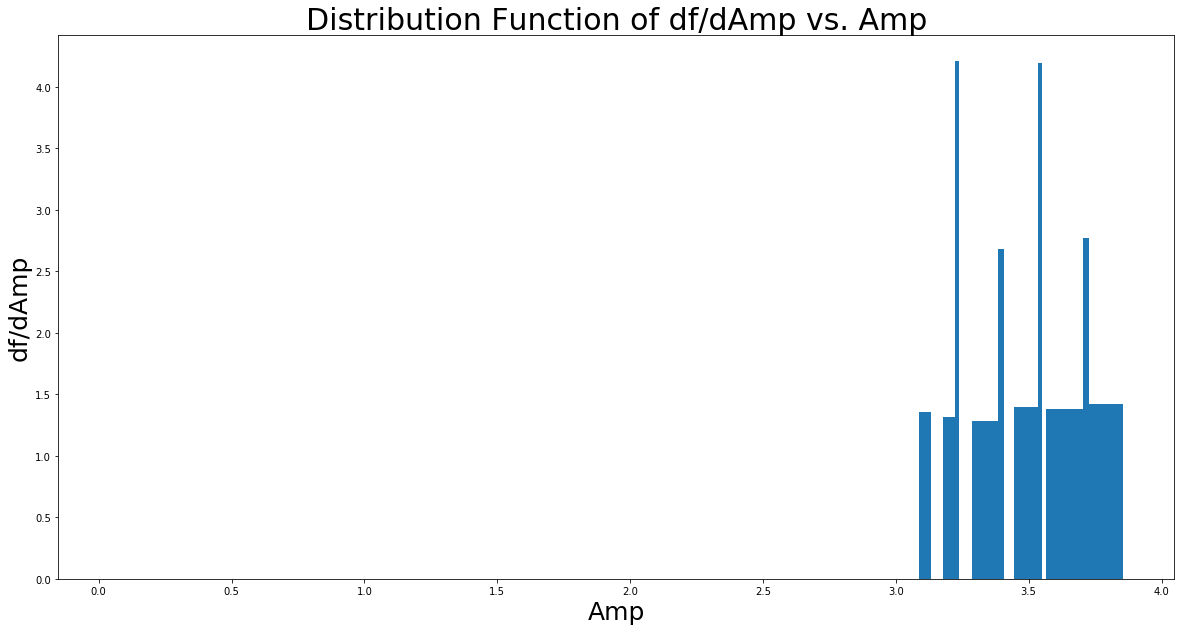

In [18]:
amp.sort()
plt.figure(figsize=(20,10))
# Density = True normalizes the curve
plt.hist(dfdAmp, amp, density=True)

plt.title('Distribution Function of df/dAmp vs. Amp',  **title_font)
plt.xlabel('Amp', **axis_font)
plt.ylabel('df/dAmp', **axis_font)
plt.show()

In [19]:
dutycycle = []
sum=0
for i in range(len(amp)):
    for j in range (i, len(amp), 1):
        sum+=(dfdAmp[j]*amp[j])
    dutycycle.append(sum)

print(len(dutycycle))

1074


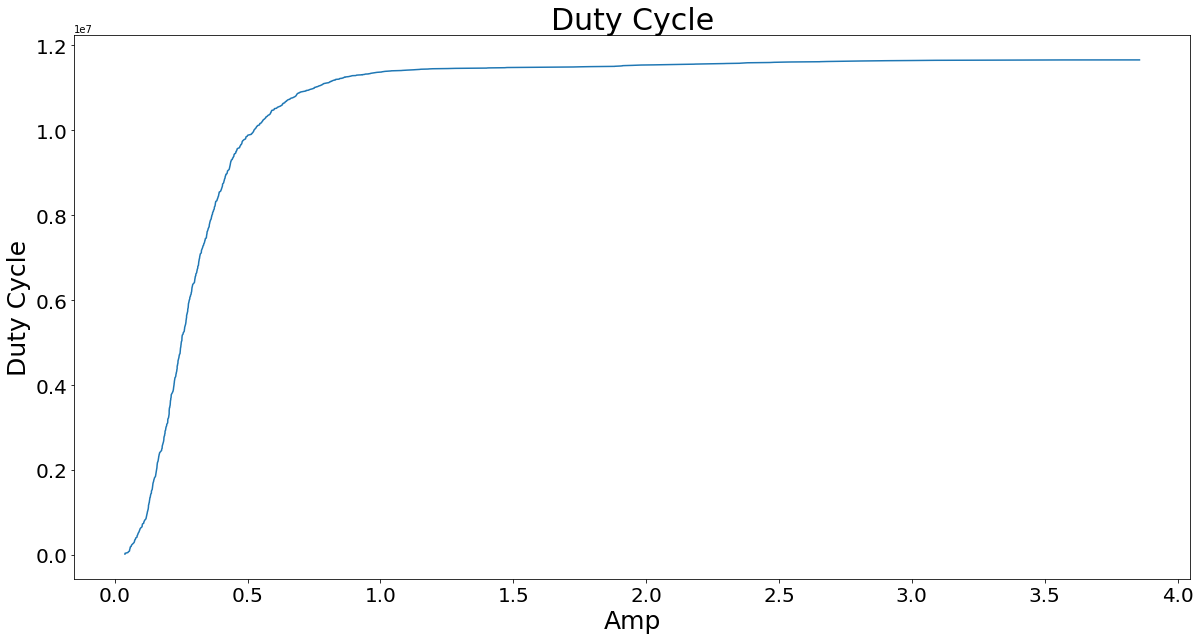

In [20]:

plt.figure(figsize=(20,10))
plt.plot(amp,dutycycle)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Duty Cycle',  **title_font)
plt.xlabel('Amp', **axis_font)
plt.ylabel('Duty Cycle', **axis_font)
plt.show()